In [178]:
import whitebox
import glob
import rasterio
import geopandas as gpd
from shapely.geometry import box
from rasterio.plot import show
from rasterio import open as rio_open
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.crs import CRS
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

import ee
import geemap

wbt = whitebox.WhiteboxTools()
ee.Initialize()

In [114]:
mos_path = "NYS_Testing/Rasters/NYS_combined_dem.tif"

In [115]:
fc = ee.FeatureCollection("projects/sat-io/open-datasets/NWI/wetlands/NY_Wetlands")

In [156]:
Map = geemap.Map(center = [42.50, -75.83], zoom = 14)
Map.add_basemap('USGS.USImagery')
#Map.add_layer(fc, {}, "NWI")
Map

Map(center=[42.5, -75.83], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [117]:
crs_3857 = CRS.from_string('EPSG:3857')
crs_3857

CRS.from_epsg(3857)

In [118]:
dem_mos = rio_open(mos_path, mode="r+")
dem_mos.crs = CRS.from_epsg(6347)
dem_mos.crs

CRS.from_epsg(6347)

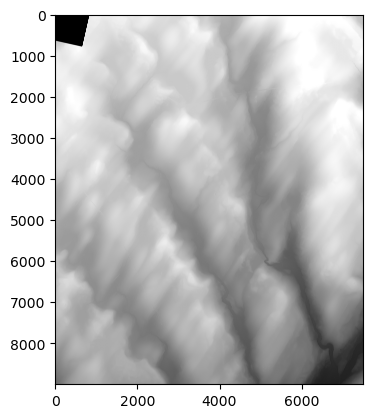

In [119]:
dem_mos_array = dem_mos.read(1)
dem_mos_array.shape
plt.imshow(dem_mos_array, cmap="gray", vmax=500, vmin=300)

In [182]:
dst_crs = 'EPSG:4326'
dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
    dem_mos.crs,
    dst_crs,
    dem_mos.width,
    dem_mos.height,
    *dem_mos.bounds
)
dst_kwargs = dem_mos.meta.copy()
dst_kwargs.update({
    'crs': dst_crs,
    'transform': dst_transform,
    'width': dst_width,
    'height': dst_height
})
dem_mos_rpj = rasterio.open('NYS_Testing/Rasters/NYS_combined_dem_prj.tif', 'w', **dst_kwargs)

rasterio.warp.reproject(
    source=rasterio.band(dem_mos, 1),
    destination=rasterio.band(dem_mos_rpj, 1),
    src_transform=dem_mos.transform,
    src_crs=dem_mos.crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=rasterio.enums.Resampling.bilinear
)
dem_mos_rpj.close()

In [183]:
dem_mos_rpj = rio_open("NYS_Testing/Rasters/NYS_combined_dem_prj.tif")
dem_mos_rpj.bounds

BoundingBox(left=-75.86426691884093, bottom=42.43108038507448, right=-75.77199914738758, top=42.51276536073047)

In [184]:
mos_bounds = dem_mos_rpj.bounds
mos_bounds

BoundingBox(left=-75.86426691884093, bottom=42.43108038507448, right=-75.77199914738758, top=42.51276536073047)

In [197]:
mos_ee = ee.Geometry.Rectangle(mos_bounds)

Map.addLayer(mos_ee, {}, "mosaic bounds")

In [201]:
nwi = (
    ee.FeatureCollection("projects/sat-io/open-datasets/NWI/wetlands/NY_Wetlands")
    .filterBounds(mos_ee)
    .filter(ee.Filter.neq("WETLAND_TY", "Riverine"))
      )
nwi

In [202]:
Map.addLayer(nwi, {}, "NWI filteredBounds")